# **Amazon Lookout for Equipment** - Getting started
*Part 5 - Scheduling regular inference calls*

## Initialization
---
This repository is structured as follow:

```sh
. lookout-equipment-demo
|
├── data/
|   ├── interim                          # Temporary intermediate data are stored here
|   ├── processed                        # Finalized datasets are usually stored here
|   |                                    # before they are sent to S3 to allow the
|   |                                    # service to reach them
|   └── raw                              # Immutable original data are stored here
|
├── getting_started/
|   ├── 1_data_preparation.ipynb
|   ├── 2_dataset_creation.ipynb
|   ├── 3_model_training.ipynb
|   ├── 4_model_evaluation.ipynb
|   ├── 5_inference_scheduling.ipynb     <<< THIS NOTEBOOK <<<
|   └── 6_cleanup.ipynb
|
└── utils/
    └── lookout_equipment_utils.py
```

### Notebook configuration update
Amazon Lookout for Equipment being a very recent service, we need to make sure that we have access to the latest version of the AWS Python packages. If you see a `pip` dependency error, check that the `boto3` version is ok before moving forward.

In [1]:
!pip install --quiet --upgrade boto3 sagemaker tqdm

import boto3
print(f'boto3 version: {boto3.__version__} (should be >= 1.17.48 to include Lookout for Equipment API)')

# Restart the current notebook to ensure we take into account the previous updates:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

boto3 version: 1.17.50 (should be >= 1.17.48 to include Lookout for Equipment API)


### Imports

In [3]:
import boto3
import config
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import os
import pandas as pd
import pytz
import sagemaker
import sys
import time

# Helper functions for managing Lookout for Equipment API calls:
sys.path.append('../utils')
import lookout_equipment_utils as lookout

### Parameters

In [4]:
TMP_DATA       = os.path.join('..', 'data', 'interim', 'getting-started')
PROCESSED_DATA = os.path.join('..', 'data', 'processed', 'getting-started')
INFERENCE_DATA = os.path.join(PROCESSED_DATA, 'inference-data')
TRAIN_DATA     = os.path.join(PROCESSED_DATA, 'training-data', 'centrifugal-pump')

os.makedirs(INFERENCE_DATA, exist_ok=True)
os.makedirs(os.path.join(INFERENCE_DATA, 'input'), exist_ok=True)
os.makedirs(os.path.join(INFERENCE_DATA, 'output'), exist_ok=True)

ROLE_ARN                 = sagemaker.get_execution_role()
REGION_NAME              = boto3.session.Session().region_name
BUCKET                   = config.BUCKET
PREFIX                   = config.PREFIX_INFERENCE
INFERENCE_SCHEDULER_NAME = config.INFERENCE_SCHEDULER_NAME
MODEL_NAME               = config.MODEL_NAME

%matplotlib inline
plt.style.use('Solarize_Light2')
plt.rcParams['lines.linewidth'] = 0.5

## Create an inference scheduler
---
While navigating to the model details part of the console, you will see that you have no inference scheduled yet:

![Schedule Starting point](assets/schedule_start.png)

### Scheduler configuration
Let's create a new inference schedule: some parameters are mandatory, while others offer some added flexibility.

#### Parameters

* Set `DATA_UPLOAD_FREQUENCY` at which the data will be uploaded for inference. Allowed values are `PT5M`, `PT10M`, `PT15M`, `PT30M` and `PT1H`.
  * This is both the frequency of the inference scheduler and how often data are uploaded to the source bucket.
  *  **Note**: ***the upload frequency must be compatible with the sampling rate selected at training time.*** *For example, if a model was trained with a 30 minutes resampling, asking for 5 minutes won't work and you need to select either PT30M and PT1H for this parameter at inference time.*
* Set `INFERENCE_DATA_SOURCE_BUCKET` to the S3 bucket of your inference data
* Set `INFERENCE_DATA_SOURCE_PREFIX` to the S3 prefix of your inference data
* Set `INFERENCE_DATA_OUTPUT_BUCKET` to the S3 bucket where you want inference results
* Set `INFERENCE_DATA_OUTPUT_PREFIX` to the S3 prefix where you want inference results
* Set `ROLE_ARN_FOR_INFERENCE` to the role to be used to **read** data to infer on and **write** inference output

In [5]:
# Name of the model on which you want to create this inference scheduler
MODEL_NAME_FOR_CREATING_INFERENCE_SCHEDULER = MODEL_NAME

# Mandatory parameters:
INFERENCE_DATA_SOURCE_BUCKET = BUCKET
INFERENCE_DATA_SOURCE_PREFIX = f'{PREFIX}/input/'
INFERENCE_DATA_OUTPUT_BUCKET = BUCKET
INFERENCE_DATA_OUTPUT_PREFIX = f'{PREFIX}/output/'
ROLE_ARN_FOR_INFERENCE = ROLE_ARN
DATA_UPLOAD_FREQUENCY = 'PT5M'

#### Time zone parameter (optional)

You can set `INPUT_TIMEZONE_OFFSET` to the following allowed values: `+00:00`, `+00:30`, `+01:00`, ... `+11:30`, `+12:00`, `-00:00`, `-00:30`, `-01:00`, ... `-11:30`, `-12:00`.

This is the timezone the scheduler will use to find the input files to run inference for. A timezone's offset refers to how many hours the timezone is from Coordinated Universal Time (UTC).

Let's take an example:
* The current date April 5th, 2021 and time is 1pm UTC
* You're in India, which is 5 hour 30 ahead of UTC and you set the `INPUT_TIMEZONE_OFFSET` to `+05:30`
* If the scheduler wakes up at 1pm UTC, A filename called 20210405**1830**00 will be found (1pm + 5H30 = 6.30pm)

Use the following cell to convert time zone identifier (`Europe/Paris`, `US/Central`...) to a time zone offset. You can build a timezone object by leveraging the World Timezone Definition **[available here](https://gist.github.com/heyalexej/8bf688fd67d7199be4a1682b3eec7568)** or by listing the available ones using this code snippet:
```python
import pytz
for tz in pytz.all_timezones:
    print tz
```
If you want to use universal time, replace the timezone string below (`Asia/Calcutta`) by `UTC`:

In [6]:
utc_timezone = pytz.timezone("UTC")

current_timezone = pytz.timezone("Asia/Calcutta")
tz_offset = datetime.datetime.now(current_timezone).strftime('%z')
INPUT_TIMEZONE_OFFSET = tz_offset[:3] + ':' + tz_offset[3:]

#### Other optional parameters

* Set `DATA_DELAY_OFFSET_IN_MINUTES` to the number of minutes you expect the data to be delayed to upload. It's a time buffer to upload data.
* Set `TIMESTAMP_FORMAT`. The allowed values `EPOCH`, `yyyy-MM-dd-HH-mm-ss` or `yyyyMMddHHmmss`. This is the format of timestamp which is the suffix of the input data file name. This is used by Lookout Equipment to understand which files to run inference on (so that you don't need to remove previous files to let the scheduler finds which one to run on).
* Set `COMPONENT_TIMESTAMP_DELIMITER`. The allowed values `-`, `_` or ` `. This is the delimiter character that is used to separate the component from the timestamp in the input filename.

In [7]:
DATA_DELAY_OFFSET_IN_MINUTES = None
COMPONENT_TIMESTAMP_DELIMITER = '_'
TIMESTAMP_FORMAT = 'yyyyMMddHHmmss'

### Create the inference scheduler
The CreateInferenceScheduler API creates a scheduler **and** starts it: this means that this starts costing you right away. However, you can stop and start an existing scheduler at will (see at the end of this notebook):

In [8]:
scheduler = lookout.LookoutEquipmentScheduler(
    scheduler_name=INFERENCE_SCHEDULER_NAME,
    model_name=MODEL_NAME_FOR_CREATING_INFERENCE_SCHEDULER,
    region_name=REGION_NAME
)

scheduler_params = {
    'input_bucket': INFERENCE_DATA_SOURCE_BUCKET,
    'input_prefix': INFERENCE_DATA_SOURCE_PREFIX,
    'output_bucket': INFERENCE_DATA_OUTPUT_BUCKET,
    'output_prefix': INFERENCE_DATA_OUTPUT_PREFIX,
    'role_arn': ROLE_ARN_FOR_INFERENCE,
    'upload_frequency': DATA_UPLOAD_FREQUENCY,
    'delay_offset': DATA_DELAY_OFFSET_IN_MINUTES,
    'timezone_offset': INPUT_TIMEZONE_OFFSET,
    'component_delimiter': COMPONENT_TIMESTAMP_DELIMITER,
    'timestamp_format': TIMESTAMP_FORMAT
}

scheduler.set_parameters(**scheduler_params)

## Prepare the inference data
---
Let's prepare and send some data in the S3 input location our scheduler will monitor: we are going to extract 10 sequences of 5 minutes each (5 minutes being the minimum scheduler frequency). We assume that data are sampled at a rate of one data point per minute meaning that each sequence will be a CSV with 5 rows (to match the scheduler frequency). We have set aside a file we can use for inference. We need to update the timestamps to match the current time and date and then split the file in individual datasets of 5 rows each.

In [14]:
inference_df['Timestamp'] = pd.to_datetime(inference_df['Timestamp'])
inference_df = inference_df.set_index('Timestamp')

In [25]:
# Load the original inference data:
inference_fname = os.path.join(TMP_DATA, 'inference-data', 'inference.csv')
inference_df = pd.read_csv(inference_fname)
inference_df['Timestamp'] = pd.to_datetime(inference_df['Timestamp'])
inference_df = inference_df.set_index('Timestamp')

# How many sequences do we want to extract:
num_sequences = 10

# The scheduling frequency in minutes: this **MUST** match the
# resampling rate used to train the model:
frequency = 5
start = inference_df.index.min()
for i in range(num_sequences):
    end = start + datetime.timedelta(minutes=+frequency - 1)
    inference_input = inference_df.loc[start:end, :]
    start = start + datetime.timedelta(minutes=+frequency)
    
    # Rounding time to the previous X minutes 
    # where X is the selected frequency:
    filename_tm = datetime.datetime.now(current_timezone)
    filename_tm = filename_tm - datetime.timedelta(
        minutes=filename_tm.minute % frequency,
        seconds=filename_tm.second,
        microseconds=filename_tm.microsecond
    )
    filename_tm = filename_tm + datetime.timedelta(minutes=+frequency * (i))
    current_timestamp = (filename_tm).strftime(format='%Y%m%d%H%M%S')
    
    # The timestamp inside the file are in UTC and are not linked to the current timezone:
    timestamp_tm = datetime.datetime.now(utc_timezone)
    timestamp_tm = timestamp_tm - datetime.timedelta(
        minutes=timestamp_tm.minute % frequency,
        seconds=timestamp_tm.second,
        microseconds=timestamp_tm.microsecond
    )
    timestamp_tm = timestamp_tm + datetime.timedelta(minutes=+frequency * (i))
    
    # We need to reset the index to match the time 
    # at which the scheduler will run inference:
    new_index = pd.date_range(
        start=timestamp_tm,
        periods=inference_input.shape[0], 
        freq='1min'
    )
    inference_input.index = new_index
    inference_input.index.name = 'Timestamp'
    inference_input = inference_input.reset_index()
    inference_input['Timestamp'] = inference_input['Timestamp'].dt.strftime('%Y-%m-%dT%H:%M:%S.%f')
    
    # Export this file in CSV format:
    scheduled_fname = os.path.join(INFERENCE_DATA, 'input', f'centrifugal-pump_{current_timestamp}.csv')
    inference_input.to_csv(scheduled_fname, index=None)
    
# Upload the whole folder to S3, in the input location:
!aws s3 cp --recursive --quiet $INFERENCE_DATA/input s3://$BUCKET/$PREFIX/input

Our S3 bucket is now in the following state: this emulates what you could expect if your industrial information system was sending a new sample of data every five minutes.

Note how:
* Every files are located in the same folder
* Each file has the recorded timestamp in its name
* The timestamps are rounding to the closest 5 minutes (as our scheduler is configured to wake up every 5 minutes)

![Inference input](assets/schedule_inference_s3_data.png)

Now that we've prepared the data, we can create the scheduler by running:

```python
create_scheduler_response = lookout_client.create_inference_scheduler({
    'ClientToken': uuid.uuid4().hex
})
```

The following method encapsulates the call to the [**CreateInferenceScheduler**](https://docs.aws.amazon.com/lookout-for-equipment/latest/ug/API_CreateInferenceScheduler.html) API:

In [28]:
create_scheduler_response = scheduler.create()

===== Polling Inference Scheduler Status =====

Scheduler Status: PENDING
Scheduler Status: RUNNING

===== End of Polling Inference Scheduler Status =====


Our scheduler is now running and its inference history is currently empty:

![Scheduler created](assets/schedule_created.png)

## Get inference results
---

### List inference executions

**Let's now wait for 5-15 minutes to give some time to the scheduler to run its first inferences.** Once the wait is over, we can use the ListInferenceExecution API for our current inference scheduler. The only mandatory parameter is the scheduler name.

You can also choose a time period for which you want to query inference executions for. If you don't specify it, then all executions for an inference scheduler will be listed. If you want to specify the time range, you can do this:

```python
START_TIME_FOR_INFERENCE_EXECUTIONS = datetime.datetime(2010,1,3,0,0,0)
END_TIME_FOR_INFERENCE_EXECUTIONS = datetime.datetime(2010,1,5,0,0,0)
```

Which means the executions after `2010-01-03 00:00:00` and before `2010-01-05 00:00:00` will be listed.

You can also choose to query for executions in particular status, the allowed status are `IN_PROGRESS`, `SUCCESS` and `FAILED`.

The following cell use `scheduler.list_inference_executions()` as a wrapper around the [**ListInferenceExecutions**](https://docs.aws.amazon.com/lookout-for-equipment/latest/ug/API_ListInferenceExecutions.html) API:

```python
    list_executions_response = lookout_client.list_inference_executions({
        "MaxResults": 50,
        "InferenceSchedulerName": INFERENCE_SCHEDULER_NAME,
        "Status": EXECUTION_STATUS,
        "DataStartTimeAfter": START_TIME_FOR_INFERENCE_EXECUTIONS,
        "DataEndTimeBefore": END_TIME_FOR_INFERENCE_EXECUTIONS
    })
```

In [32]:
START_TIME_FOR_INFERENCE_EXECUTIONS = None
END_TIME_FOR_INFERENCE_EXECUTIONS = None
EXECUTION_STATUS = None

execution_summaries = []

while len(execution_summaries) == 0:
    execution_summaries = scheduler.list_inference_executions(
        start_time=START_TIME_FOR_INFERENCE_EXECUTIONS,
        end_time=END_TIME_FOR_INFERENCE_EXECUTIONS,
        execution_status=EXECUTION_STATUS
    )
    if len(execution_summaries) == 0:
        print('WAITING FOR THE FIRST INFERENCE EXECUTION')
        time.sleep(60)
        
    else:
        print('FIRST INFERENCE EXECUTED\n')
        break
            
execution_summaries

FIRST INFERENCE EXECUTED



[{'ModelName': 'getting-started-pump-5min-model',
  'ModelArn': 'arn:aws:lookoutequipment:eu-west-1:123031033346:model/getting-started-pump-5min-model/4b8327d6-fc28-420c-b6f0-e7fb9a6be502',
  'InferenceSchedulerName': 'getting-started-pump-5min-scheduler',
  'InferenceSchedulerArn': 'arn:aws:lookoutequipment:eu-west-1:123031033346:inference-scheduler/getting-started-pump-5min-scheduler/5b916601-a09d-4127-ac42-f6c0a9e9f9ed',
  'ScheduledStartTime': datetime.datetime(2021, 4, 13, 14, 20, tzinfo=tzlocal()),
  'DataStartTime': datetime.datetime(2021, 4, 13, 14, 15, tzinfo=tzlocal()),
  'DataEndTime': datetime.datetime(2021, 4, 13, 14, 20, tzinfo=tzlocal()),
  'DataInputConfiguration': {'S3InputConfiguration': {'Bucket': 'lookout-equipment-getting-started',
    'Prefix': 'getting_started/inference-data/input/'}},
  'DataOutputConfiguration': {'S3OutputConfiguration': {'Bucket': 'lookout-equipment-getting-started',
    'Prefix': 'getting_started/inference-data/output/'}},
  'CustomerResultOb

We have configured this scheduler to run every five minutes. After at least 5 minutes we can also see the history in the console populated with its first few executions: after an hour or so, we will see that the last one failed as we only generated 10 files above and the scheduler did find the last one at the time it was fired:

![Inference history](assets/schedule_inference_history.png)

When the scheduler starts (for example at `datetime.datetime(2021, 1, 27, 9, 15)`, it looks for **a single** CSV file located in the input location with a filename that contains a timestamp set to the previous step. For example, a file named:

* centrifugal-pump_2021012709**10**00.csv will be found and ingested
* centrifugal-pump_2021012708**15**00.csv will **not be** ingested (it will be ingested at the next inference execution however)

In addition, when opening the file `centrifugal-pump_20210127091000.csv`, it will look for any row with a date that is between the `DataStartTime` and the `DataEndTime` of the inference execution. If it doesn't find such a row, an exception will be thrown.

### Download inference results
Let's have a look at the content now available in the scheduler output location: each inference execution creates a subfolder in the output directory. The subfolder name is the timestamp (GMT) at which the inference was executed and it contains a single [JSON lines](https://jsonlines.org/) file named `results.jsonl`:

![Inference input](assets/schedule_inference_output_data.png)

Each execution summary is a JSON document that has the following format:

In [33]:
execution_summaries[0]

{'ModelName': 'getting-started-pump-5min-model',
 'ModelArn': 'arn:aws:lookoutequipment:eu-west-1:123031033346:model/getting-started-pump-5min-model/4b8327d6-fc28-420c-b6f0-e7fb9a6be502',
 'InferenceSchedulerName': 'getting-started-pump-5min-scheduler',
 'InferenceSchedulerArn': 'arn:aws:lookoutequipment:eu-west-1:123031033346:inference-scheduler/getting-started-pump-5min-scheduler/5b916601-a09d-4127-ac42-f6c0a9e9f9ed',
 'ScheduledStartTime': datetime.datetime(2021, 4, 13, 14, 20, tzinfo=tzlocal()),
 'DataStartTime': datetime.datetime(2021, 4, 13, 14, 15, tzinfo=tzlocal()),
 'DataEndTime': datetime.datetime(2021, 4, 13, 14, 20, tzinfo=tzlocal()),
 'DataInputConfiguration': {'S3InputConfiguration': {'Bucket': 'lookout-equipment-getting-started',
   'Prefix': 'getting_started/inference-data/input/'}},
 'DataOutputConfiguration': {'S3OutputConfiguration': {'Bucket': 'lookout-equipment-getting-started',
   'Prefix': 'getting_started/inference-data/output/'}},
 'CustomerResultObject': {'Buc

When the `Status` key from the previous JSON result is set to `SUCCESS`, you can collect the results location in the `CustomerResultObject` field. We are now going to loop through each execution result and download each JSON lines files generated by the scheduler. Then we will insert their results into an overall dataframe for further analysis:

In [73]:
# Fetch the list of execution summaries in case all executions were not captured yet:
_ = scheduler.list_inference_executions()

# Loops through the executions summaries:
results_json = []
for execution_summary in scheduler.execution_summaries:
    print('.', end='')
    
    # We only get an output if the inference execution is a sucess:
    status = execution_summary['Status']
    if status == 'SUCCESS':
        # Download the JSON-line file locally:
        bucket = execution_summary['CustomerResultObject']['Bucket']
        key = execution_summary['CustomerResultObject']['Key']
        current_timestamp = key.split('/')[-2]
        local_fname = os.path.join(INFERENCE_DATA, 'output', f'centrifugal-pump_{current_timestamp}.jsonl')
        s3_fname = f's3://{bucket}/{key}'
        
        !aws s3 cp --quiet $s3_fname $local_fname
        
        # Opens the file and concatenate the results into a dataframe:
        with open(local_fname, 'r') as f:
            content = [eval(line) for line in f.readlines()]
            results_json = results_json + content
    
# Build the final dataframes with all the results:
results_df = pd.DataFrame(results_json)
results_df['timestamp'] = pd.to_datetime(results_df['timestamp'])
results_df = results_df.set_index('timestamp')
results_df = results_df.sort_index()
results_df.head()

...............

,prediction,diagnostics
timestamp,,
2021-04-13 14:15:00,1,"[{'name': 'centrifugal-pump\Sensor0', 'value':..."
2021-04-13 14:16:00,1,"[{'name': 'centrifugal-pump\Sensor0', 'value':..."
2021-04-13 14:17:00,1,"[{'name': 'centrifugal-pump\Sensor0', 'value':..."
2021-04-13 14:18:00,1,"[{'name': 'centrifugal-pump\Sensor0', 'value':..."
2021-04-13 14:19:00,1,"[{'name': 'centrifugal-pump\Sensor0', 'value':..."


The content of each JSON lines file follows this format:
    
```json
[
    {
        'timestamp': '2021-04-07T20:00:00.000000',
        'prediction': 1,
        'diagnostics': [
            {'name': 'centrifugal-pump\\Sensor0', 'value': 0.12},
            {'name': 'centrifugal-pump\\Sensor1', 'value': 0.0},
            {'name': 'centrifugal-pump\\Sensor2', 'value': 0.0},
                                  .
                                  .
                                  .
            {'name': 'centrifugal-pump\\Sensor27', 'value': 0.08},
            {'name': 'centrifugal-pump\\Sensor28', 'value': 0.02},
            {'name': 'centrifugal-pump\\Sensor29', 'value': 0.02}
        ]
    }
    ...
]
```
Each timestamp found in the file is associated to a prediction: 1 when an anomaly is detected an 0 otherwise. When the `prediction` field is 1 (an anomaly is detected), the `diagnostics` field contains each sensor (with the format `component`\\`tag`) and an associated percentage. This percentage corresponds to the magnitude of impact of a given sensor to the detected anomaly. For instance, in the example above, the tag `Sensor0` located on the `centrifugal-pump` component has an estimated 12% magnitude of impact to the anomaly detected at 8pm on April 7th 2021. This dataset has 122 sensors: if each sensor contributed the same way to this event, the impact of each of them would be `100 / 122 = 0.82%`, so 12% is indeed statistically significant.

### Visualizing the inference results
#### Single inference analysis
Let's first expand the results to expose the content of the **diagnostics** column above into different dataframe columns:

In [74]:
expanded_results = []
for index, row in results_df.iterrows():
    new_row = dict()
    new_row.update({'timestamp': index})
    new_row.update({'prediction': row['prediction']})
    
    if row['prediction'] == 1:
        diagnostics = pd.DataFrame(row['diagnostics'])
        diagnostics = dict(zip(diagnostics['name'], diagnostics['value']))
        new_row = {**new_row, **diagnostics}
        
    expanded_results.append(new_row)
    
expanded_results = pd.DataFrame(expanded_results)
expanded_results['timestamp'] = pd.to_datetime(expanded_results['timestamp'])
expanded_results = expanded_results.set_index('timestamp')
expanded_results.head()

,prediction,centrifugal-pump\Sensor0,centrifugal-pump\Sensor1,centrifugal-pump\Sensor2,centrifugal-pump\Sensor3,centrifugal-pump\Sensor4,centrifugal-pump\Sensor5,centrifugal-pump\Sensor6,centrifugal-pump\Sensor7,centrifugal-pump\Sensor8,...,centrifugal-pump\Sensor14,centrifugal-pump\Sensor15,centrifugal-pump\Sensor16,centrifugal-pump\Sensor17,centrifugal-pump\Sensor18,centrifugal-pump\Sensor19,centrifugal-pump\Sensor20,centrifugal-pump\Sensor21,centrifugal-pump\Sensor22,centrifugal-pump\Sensor23
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-04-13 14:15:00,1,0.16000,0.00000,0.04000,0.14000,0.04000,0.08000,0.02000,0.00000,0.00000,...,0.02000,0.00000,0.00000,0.00000,0.04000,0.02000,0.08000,0.02000,0.0,0.00000
2021-04-13 14:16:00,1,0.12114,0.00972,0.05457,0.15457,0.04972,0.06057,0.01514,0.00000,0.03400,...,0.02972,0.00486,0.00000,0.00486,0.03514,0.02972,0.06057,0.01514,0.0,0.00000
2021-04-13 14:17:00,1,0.09344,0.00640,0.03594,0.11546,0.03274,0.06037,0.09191,0.06145,0.02239,...,0.03323,0.00320,0.00000,0.01686,0.02997,0.02640,0.04672,0.00997,0.0,0.00000
2021-04-13 14:18:00,1,0.10686,0.01032,0.02558,0.08795,0.02331,0.05450,0.06542,0.04374,0.03900,...,0.02941,0.00228,0.11527,0.01776,0.02134,0.01879,0.03326,0.00710,0.0,0.00000
2021-04-13 14:19:00,1,0.10319,0.00996,0.02951,0.08493,0.02251,0.05538,0.06318,0.04224,0.03766,...,0.03183,0.00563,0.11406,0.01715,0.02129,0.01815,0.03212,0.00686,0.0,0.00069


Each detected event have some detailed diagnostics. Let's unpack the details for the first event and plot a similar bar chart than what the console provides when it evaluates a trained model:

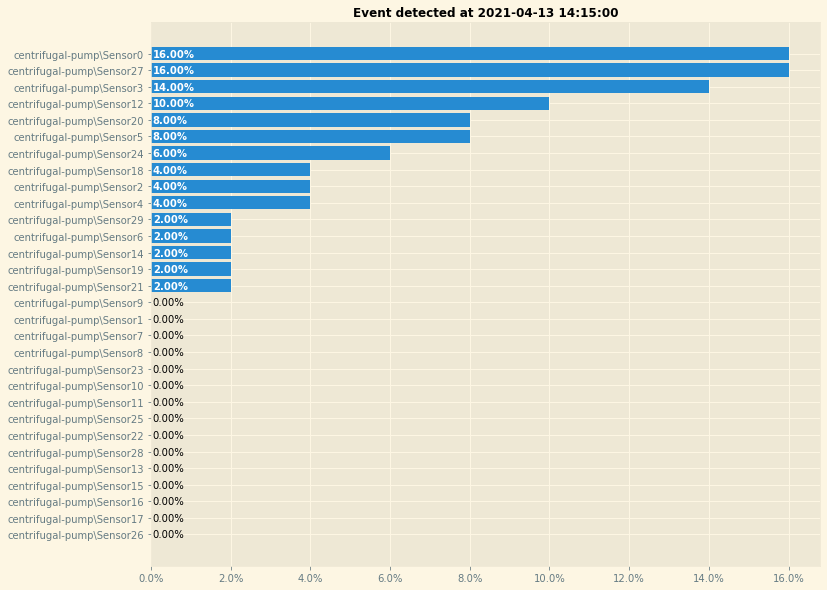

In [75]:
event_details = pd.DataFrame(expanded_results.iloc[0, 1:]).reset_index()
event_details.columns = ['name', 'value']
event_details = event_details.sort_values(by='value')

# We can then plot a horizontal bar chart:
y_pos = np.arange(event_details.shape[0])
values = list(event_details['value'])

fig = plt.figure(figsize=(12,10))
ax = plt.subplot(1,1,1)
ax.barh(y_pos, event_details['value'], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(event_details['name'])
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Add the values in each bar:
for i, v in enumerate(values):
    if v == 0:
        ax.text(0.0005, i, f'{v*100:.2f}%', color='#000000', verticalalignment='center')
    else:
        ax.text(0.0005, i, f'{v*100:.2f}%', color='#FFFFFF', fontweight='bold', verticalalignment='center')
    
plt.title(f'Event detected at {expanded_results.index[0]}', fontsize=12, fontweight='bold')
plt.show()

As we did in the previous notebook, the above bar chart is already of great help to pinpoint what might be going wrong with your asset. Let's load the initial tags description file we prepared in the first notebook and match the sensors with our initial components to group sensors by component:

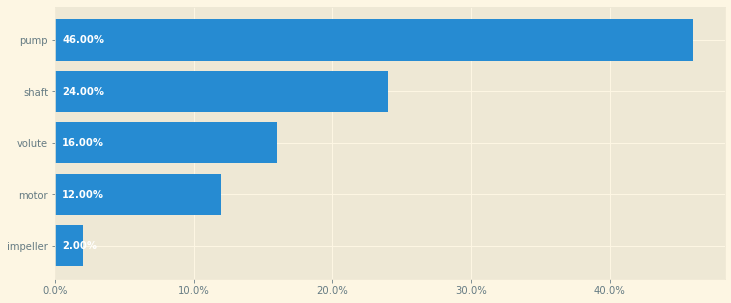

In [76]:
# Agregate event diagnostics at the component level:
tags_description_fname = os.path.join(TMP_DATA, 'tags_description.csv')
tags_description_df = pd.read_csv(tags_description_fname)
event_details[['asset', 'sensor']] = event_details['name'].str.split('\\', expand=True)
component_diagnostics = pd.merge(event_details, tags_description_df, how='inner', left_on='sensor', right_on='Tag')[['name', 'value', 'Component']]
component_diagnostics = component_diagnostics.groupby(by='Component').sum().sort_values(by='value')

# Prepare Y position and values for bar chart:
y_pos = np.arange(component_diagnostics.shape[0])
values = list(component_diagnostics['value'])

# Plot the bar chart:
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(1,1,1)
ax.barh(y_pos, component_diagnostics['value'], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(list(component_diagnostics.index))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Add the values in each bar:
for i, v in enumerate(values):
    ax.text(0.005, i, f'{v*100:.2f}%', color='#FFFFFF', fontweight='bold', verticalalignment='center')
    
# Show the final plot:
plt.show()

#### Multiple inferences analysis

We can also plot the contribution evolution for the top contributing signals over a period of time: the following graph gives an example of what a real time dashboard could look like to expose the results of an Amazon Lookout for Equipment scheduler.

**Note:** The plot stops after a while as there are no more anomaly detected.

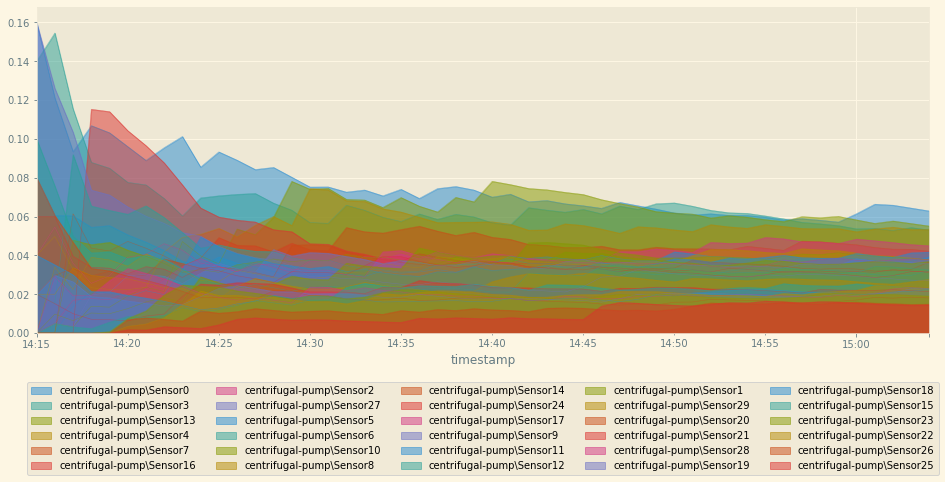

In [77]:
df = expanded_results.iloc[:, 1:]
mean_contribution = df.mean().sort_values(ascending=False)
filtered_sensors = mean_contribution.index.to_list()
df = df.loc[:, filtered_sensors]

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1,1,1)
df.plot.area(ax=ax, stacked=False)#, colormap="jet")
plt.legend(loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.45))
plt.show()

The above plot is quite busy, let's filter on the signals that are, in average, **contributing the most** across this event and focus **only on the time range when something is happening**:

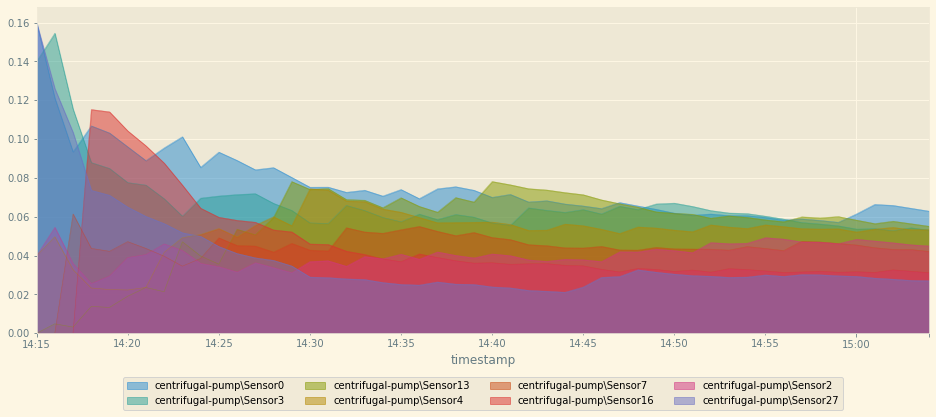

In [78]:
# Selecting the top 8 signals with the highest contribution to these events (in average):
df = expanded_results.iloc[:, 1:].dropna()
mean_contribution = df.mean().sort_values(ascending=False)
filtered_sensors = mean_contribution[:8].index.to_list()
df = df.loc[:, filtered_sensors]

# Area plot:
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1,1,1)
df.plot.area(ax=ax, stacked=False)#, colormap="jet")
plt.legend(loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.25))
plt.show()

**As previously, let's agregate these sensor data at the component level:**

In [79]:
column_index = pd.MultiIndex.from_frame(tags_description_df[['Component', 'Tag']])
components_results = expanded_results.iloc[:, 1:].dropna().copy()
components_results.columns = column_index
components_results = components_results.groupby(axis=1, level='Component').sum()
components_results.columns = list(components_results.columns)
components_results.head()

,impeller,motor,pump,shaft,volute
timestamp,,,,,
2021-04-13 14:15:00,0.02000,0.12000,0.46000,0.24000,0.16000
2021-04-13 14:16:00,0.05400,0.12001,0.45029,0.23515,0.14057
2021-04-13 14:17:00,0.24041,0.10635,0.34435,0.19584,0.11306
2021-04-13 14:18:00,0.23453,0.21978,0.30852,0.15669,0.08049
2021-04-13 14:19:00,0.23128,0.22390,0.30548,0.16023,0.07911


It looks like the pump is the first area where an anomaly is visible before each component becomes more balanced in the way they contribute to this detected event. However, the sensors associated to **the pump stays at the very high level** along this particular event which may call to a specific course of action:

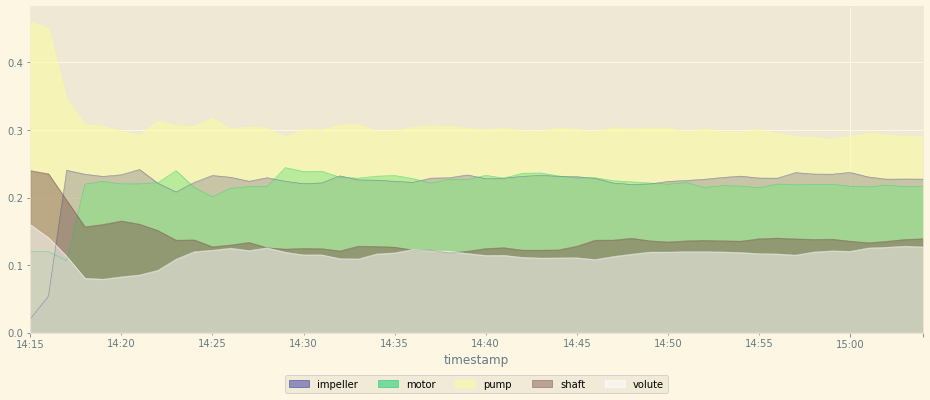

In [80]:
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1,1,1)
components_results.plot.area(ax=ax, stacked=False, colormap="terrain")
plt.legend(loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.20))
plt.show()

## Inference scheduler operations
---
### Stop inference scheduler
**Be frugal**, running the scheduler is the main cost driver of Amazon Lookout for Equipment. Use the [**StopInferenceScheduler**](https://docs.aws.amazon.com/lookout-for-equipment/latest/ug/API_StopInferenceScheduler.html) API to stop an already running inference scheduler:

```python
stop_scheduler_response = lookout_client.stop_inference_scheduler(
    InferenceSchedulerName=INFERENCE_SCHEDULER_NAME
)
```

The following method is a wrapper around this API call and will stop the periodic inference executions:

In [82]:
scheduler.stop()

===== Polling Inference Scheduler Status =====

Scheduler Status: STOPPING
Scheduler Status: STOPPED

===== End of Polling Inference Scheduler Status =====


### Start an inference scheduler
You can restart any `STOPPED` inference scheduler using the [**StartInferenceScheduler**](https://docs.aws.amazon.com/lookout-for-equipment/latest/ug/API_StartInferenceScheduler.html) API:

```python
start_scheduler_response = lookout_client.start_inference_scheduler(
    InferenceSchedulerName=INFERENCE_SCHEDULER_NAME
)
```

The following method is a wrapper around this API call and will start the periodic inference executions:

In [83]:
scheduler.start()

===== Polling Inference Scheduler Status =====

Scheduler Status: PENDING
Scheduler Status: RUNNING

===== End of Polling Inference Scheduler Status =====


### Delete an inference scheduler
You can delete a **stopped** scheduler you have no more use of: note that you can only have one scheduler per model.

```python
delete_scheduler_response = lookout_client.delete_inference_scheduler(
    InferenceSchedulerName=INFERENCE_SCHEDULER_NAME
)
```

The `scheduler.delete()` method is a wrapper around the [**DeleteInferenceScheduler**](https://docs.aws.amazon.com/lookout-for-equipment/latest/ug/API_DeleteInferenceScheduler.html) API and will delete a stopped scheduler:

In [84]:
scheduler.stop()
scheduler.delete()

===== Polling Inference Scheduler Status =====

Scheduler Status: STOPPING
Scheduler Status: STOPPED

===== End of Polling Inference Scheduler Status =====


{'ResponseMetadata': {'RequestId': '0bf024d5-33fd-4f8a-9783-dfc23f508f4a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '0bf024d5-33fd-4f8a-9783-dfc23f508f4a',
   'content-type': 'application/x-amz-json-1.0',
   'content-length': '0',
   'date': 'Tue, 13 Apr 2021 15:34:53 GMT'},
  'RetryAttempts': 0}}

## Conclusion
---

In this notebook, we used the model created in part 3 of this notebook, configured a scheduler and extracted the predictions obtained after it executed a few inferences.

We also showed how we could post-process the inference results to deliver better insights into the detected events.